In [1]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

%cd '/content/drive/MyDrive/Lung_DATASET1/'

/content/drive/.shortcut-targets-by-id/1I0oT44NlrKI0VgrIRYi261rmfqwwTQvr/Lung_DATASET1


In [10]:
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras


In [11]:
import tensorflow as tf
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import time

In [14]:
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)


batchsize = 10
train_generator=train_dataset.flow_from_directory('/content/drive/MyDrive/Lung_DATASET1/train/',
                                                  target_size=(640, 640),
                                                  batch_size=batchsize,
                                                  class_mode='categorical')

validation_generator = validation_dataset.flow_from_directory('/content/drive/MyDrive/Lung_DATASET1/valid',
        target_size=(640, 640),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('/content/drive/MyDrive/Lung_DATASET1/test/',
       target_size=(640, 640),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#**DENSENET121**

In [15]:
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **VGG19**

In [16]:
base_model2=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [17]:
base_model3=tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)

478307632/478307632 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Setting all layers as non-trainable**

In [18]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model2.layers:
    layer.trainable=False

Defining custom activation function

In [19]:
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

Defining convolution batch normalization function with swish activation

In [20]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)
    return x

**Defining Inception Block:**

Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [21]:
def Inception(x,nb_filter):
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))

    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))

    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))

    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))

    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)
    return x

Adding new layers in model architechture

In [25]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, concatenate
from tensorflow.keras.models import Model

# ---------------- Conv2D + BN + ReLU ----------------
def Conv2d_BN(x, filters, kernel_size, strides=(1,1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   # no Lambda needed
    return x

# ---------------- Inception Block ----------------
def Inception(x, filters):
    # Branch 1x1
    branch1 = Conv2d_BN(x, filters // 4, (1,1))

    # Branch 3x3
    branch3 = Conv2d_BN(x, filters // 4, (3,3))

    # Branch 5x5
    branch5 = Conv2d_BN(x, filters // 4, (5,5))

    # Branch pooling
    branch_pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    branch_pool = Conv2d_BN(branch_pool, filters // 4, (1,1))

    # Concatenate all branches
    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x


# ---------------- DenseNet121 ----------------
x = base_model1.layers[-6].output

x = Conv2d_BN(x, 512, (3,3), strides=(1,1), padding='same')
x = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(x)

x = Inception(x, 512)
x = Inception(x, 512)

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(3, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)


# ---------------- VGG19 ----------------
x = base_model2.layers[-6].output

x = Conv2d_BN(x, 512, (3,3), strides=(1,1), padding='same')
x = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(x)

x = Inception(x, 512)
x = Inception(x, 512)

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(3, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)


# ---------------- EfficientNetV2L ----------------
x = base_model3.layers[-6].output   # ✅ fixed to base_model3

x = Conv2d_BN(x, 512, (3,3), strides=(1,1), padding='same')
x = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(x)

x = Inception(x, 512)
x = Inception(x, 512)

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(3, activation='softmax')(x)   # ✅ fixed variable name
model3 = Model(inputs=base_model3.input, outputs=predictions_3)


In [26]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 11,908,675 (45.43 MB)

 Trainable params: 4,872,195 (18.59 MB)

 Non-trainable params: 7,036,480 (26.84 MB)

In [27]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 28, 28,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv4[0][

 Total params: 27,111,491 (103.42 MB)

 Trainable params: 7,084,035 (27.02 MB)

 Non-trainable params: 20,027,456 (76.40 MB)

**Tuning**

In [28]:
base_model1.trainable = True
base_model2.trainable = True

In [29]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

In [30]:
base_learning_rate=0.0001

In [33]:
model1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

model3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)



In [41]:
history_fine1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=initial_epochs + fine_tune_epochs,                        # total = initial + fine-tune
    initial_epoch=initial_epochs,               # start from epoch 10
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    verbose=1
)



Epoch 11/20


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 640, 640, 3)

In [37]:
#model1.save('D121.h5')

In [42]:
acc = history_fine1.history['accuracy']
val_acc = history_fine1.history['val_accuracy']

loss = history_fine1.history['loss']
val_loss = history_fine1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('D121 RIM ONE Random(Tuned)', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'history_fine1' is not defined

In [43]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix ')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['BenginCases', 'MalignantCases','normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

34/34 [==============================] - 11s 269ms/step
Confusion Matrix 
[[  0  18   9]
 [  4 218   8]
 [  0   2  73]]
Classification Report
                precision    recall  f1-score   support

   BenginCases       0.00      0.00      0.00        27
MalignantCases       0.92      0.95      0.93       230
        normal       0.81      0.97      0.88        75

      accuracy                           0.88       332
     macro avg       0.58      0.64      0.61       332
  weighted avg       0.82      0.88      0.85       332



In [ ]:
import itertools

Text(0.5, 23.52222222222222, 'Predicted label')

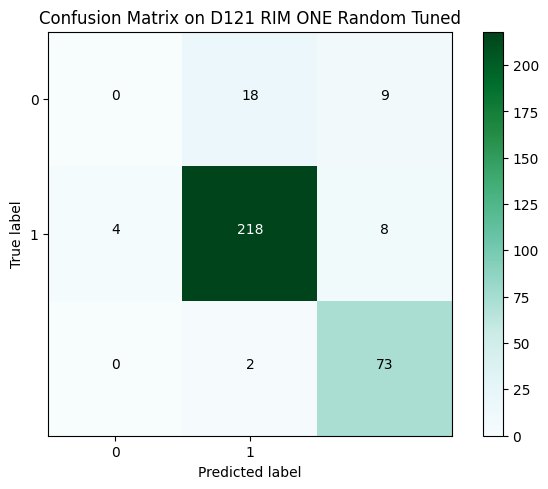

In [ ]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix on D121 RIM ONE Random Tuned")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
pip install pillow

In [ ]:
fine_tune_epochs = 10
initial_epochs= 10
batch_size=10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine3 = model2.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=total_epochs, batch_size =batch_size,
      validation_data=validation_generator,
     #initial_epoch=50,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


354/354 [==============================] - 354s 952ms/step - loss: 0.6659 - accuracy: 0.5126 - val_loss: 0.6559 - val_accuracy: 0.4434
Epoch 2/20
354/354 [==============================] - 326s 919ms/step - loss: 0.6458 - accuracy: 0.5701 - val_loss: 0.6552 - val_accuracy: 0.3823
Epoch 3/20
354/354 [==============================] - 326s 921ms/step - loss: 0.6314 - accuracy: 0.6139 - val_loss: 0.6568 - val_accuracy: 0.3823
Epoch 4/20
354/354 [==============================] - 326s 920ms/step - loss: 0.6203 - accuracy: 0.6466 - val_loss: 0.6578 - val_accuracy: 0.3670
Epoch 5/20
254/354 [====================>.........] - ETA: 1:26 - loss: 0.6120 - accuracy: 0.6601

In [ ]:
acc = history_fine3.history['accuracy']
val_acc = history_fine3.history['val_accuracy']

loss = history_fine3.history['loss']
val_loss = history_fine3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.suptitle('VGG19 on RIM ONE Random(Tuned)', fontsize=14, fontweight='bold')
plt.xlabel('epoch')
plt.show()

In [ ]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model2.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['BenginCases', 'MalignantCases','normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix Tuned RIM ONE Random VGG19")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')